<a href="https://colab.research.google.com/github/mar2nyuedu/colab/blob/main/Mohammed_Rahman_Project_Multi_Shuffled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a Network Intrusion Detection problem. Given a set of network connection records, we need to classify these records as network attacks or regular traffic.
## NSL-KDD (Network Security Lab-KDD) is a dataset for network intrusion detection research. The NSL-KDD dataset contains network traffic data generated by different types of attacks on a simulated network environment.
## The dataset is divided into two sets: the training set and the testing set. The dataset contains 42 features for each connection record, such as protocol type, service, flag, and various other statistics. Additionally, it includes a label for each record indicating whether it represents normal traffic or one of the 22 different attack types.
## There are 125,973 records in the training dataset and 22,544 records in the test dataset. There are 23 types of attack in the training dataset but 38 types of attack in the test dataset.
# Researchers and developers use the NSL-KDD dataset to train and evaluate intrusion detection models, enabling them to identify and classify network traffic patterns and develop algorithms that can detect and prevent cyber-attacks.

Load and Configure Python Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,mean_absolute_error, make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras.layers import Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import seaborn as sns


# Ignore all warnings
warnings.simplefilter(action='ignore', category=Warning)

# set pandas columns
pd.set_option('display.max_columns', 50)



Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Training and Test Data, Mix them up, drop duplicates and separate them again.

In [3]:
#Read the data from the CSV file

df_train = pd.read_csv('/content/drive/MyDrive/Project/KDDTrainLabeled.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Project/KDDTestLabeled.csv')

print("Training rows:", len(df_train))
print("Testing rows:", len(df_test))

#combine them together in one dataset
df_combined = pd.concat([df_train, df_test]) 

print("combined rows:", len(df_combined))
df_combined=df_combined.drop_duplicates()
print("combined rows:", len(df_combined))

random_state = 42
# Shuffle the combined dataset
df_combined = df_combined.sample(frac=1, random_state=random_state)

# Split the dataset into training and test sets
train_rows = 125973
df_train = df_combined[:train_rows]
df_test = df_combined[train_rows:]

# Print the number of rows in each DataFrame
print("Training rows:", len(df_train))
print("Testing rows:", len(df_test))

Training rows: 125973
Testing rows: 22544
combined rows: 148517
combined rows: 147907
Training rows: 125973
Testing rows: 21934


Let's view some of the training and test data

In [4]:
df_train.head(5)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
107656,0,tcp,http,SF,324,1000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,50,50,0.0,0.0,0.0,0.0,1.0,0.0,0.00,143,255,1.00,0.00,0.01,0.02,0.0,0.0,0.0,0.0,normal,21
62150,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,197,0.77,0.02,0.77,0.00,0.0,0.0,0.0,0.0,smurf,19
48550,1,tcp,smtp,SF,1302,328,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0.0,0.0,0.0,0.0,1.0,0.0,1.00,24,93,0.88,0.17,0.04,0.03,0.0,0.0,0.0,0.0,normal,21
38757,0,udp,domain_u,SF,44,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,110,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,254,1.00,0.01,0.00,0.00,0.0,0.0,0.0,0.0,normal,20
56706,0,tcp,http,SF,316,893,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,6,0.0,0.0,0.0,0.0,1.0,0.0,0.33,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal,21


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125973 entries, 107656 to 103709
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  

In [6]:
df_test.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
9155,0,tcp,pop_3,SF,36,237,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,9,0.04,0.02,0.00,0.00,0.0,0.0,0.00,0.00,guess_passwd,1
24448,0,tcp,domain,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,1.0,1.0,0.0,0.0,0.33,0.25,0.00,255,10,0.04,0.07,0.00,0.00,1.0,1.0,0.00,0.00,neptune,18
110224,0,tcp,http,SF,218,321,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,33,33,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,normal,21
104031,0,tcp,http,SF,214,15405,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,12,0.0,0.0,0.0,0.0,1.00,0.00,0.25,115,255,1.00,0.00,0.01,0.01,0.0,0.0,0.02,0.01,normal,21
1986,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,118,11,1.0,1.0,0.0,0.0,0.09,0.06,0.00,78,11,0.14,0.08,0.01,0.00,1.0,1.0,0.00,0.00,neptune,18


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21934 entries, 9155 to 121958
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     21934 non-null  int64  
 1   protocol_type                21934 non-null  object 
 2   service                      21934 non-null  object 
 3   flag                         21934 non-null  object 
 4   src_bytes                    21934 non-null  int64  
 5   dst_bytes                    21934 non-null  int64  
 6   land                         21934 non-null  int64  
 7   wrong_fragment               21934 non-null  int64  
 8   urgent                       21934 non-null  int64  
 9   hot                          21934 non-null  int64  
 10  num_failed_logins            21934 non-null  int64  
 11  logged_in                    21934 non-null  int64  
 12  num_compromised              21934 non-null  int64  
 13  root_shell  

Let's check if there is any missing data in both training and test dataset

In [8]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [9]:
df_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

Wow! Both the training and test data is free from any null values

Let's Visualize the data

In [10]:
def visualize(df_train, df_test,attribute):
  fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(25, 7.5), dpi=100)

  fig.suptitle(f'Counts of Observations', fontsize=25)

  sns.countplot(x=attribute, 
              palette="OrRd_r", 
              data=df_train, 
              order=df_train[attribute].value_counts().index,
              ax=ax1)

  ax1.set_title('Train Set', fontsize=20)
  ax1.set_xlabel(attribute, fontsize=15)
  ax1.set_ylabel('count', fontsize=15)
  ax1.tick_params(labelrotation=90)

  sns.countplot(x=attribute, 
              palette="GnBu_r", 
              data=df_test, 
              order=df_test[attribute].value_counts().index,
              ax=ax2)

  ax2.set_title('Test Set', fontsize=20)
  ax2.set_xlabel(attribute, fontsize=15)
  ax2.set_ylabel('count', fontsize=15)
  ax2.tick_params(labelrotation=90)

  plt.show()

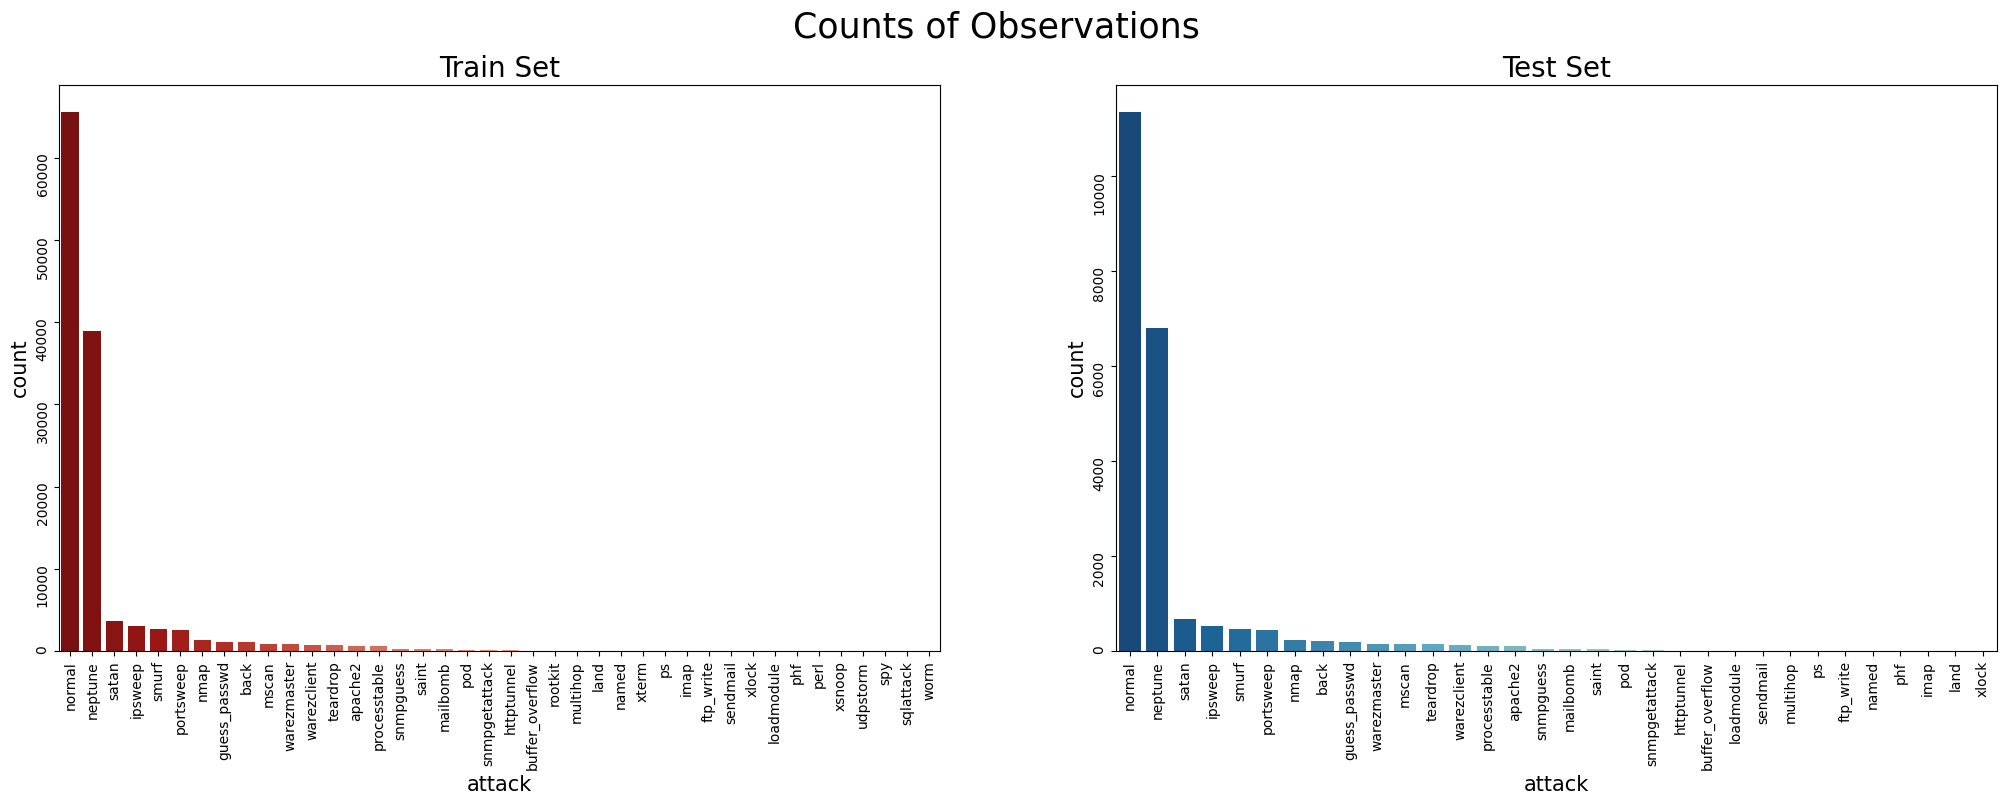

In [11]:
visualize(df_train,df_test,'attack')

Uh-oh! The data is imbalanced in a major way. Most of the connections are either 'normal' or 'neptune' attack both in training and test dataset. That's a problem training the model for other categories of attack. The second problem is there are categories in the testset (like saint, mailbomb) that do not exist in the training set. Also, there is merely any guess_passwd attack on the training set but a lot in the test set. How can we train our model without any or very low examples? We have to do something to resolve these issues.


In [12]:
print("Traning Data breakdown: ")
print("total number of rows: "  + str(df_train["attack"].count()))
print("normal rows         : " + str((df_train['attack'] == 'normal').sum()))
print("neptune rows        : " + str((df_train['attack'] == 'neptune').sum()))
print("other rows          : " + str(((df_train['attack'] != 'normal') & (df_train['attack'] != 'neptune')).sum()))
print()
print("Test Data breakdown: ")
print("total number of rows: "  + str(df_test["attack"].count()))
print("normal rows         : " + str((df_test['attack'] == 'normal').sum()))
print("neptune rows        : " + str((df_test['attack'] == 'neptune').sum()))
print("other rows          : " + str(((df_test['attack'] != 'normal') & (df_test['attack'] != 'neptune')).sum()))


Traning Data breakdown: 
total number of rows: 125973
normal rows         : 65607
neptune rows        : 38915
other rows          : 21451

Test Data breakdown: 
total number of rows: 21934
normal rows         : 11360
neptune rows        : 6801
other rows          : 3773


There is just too much of 'normal' and 'neptune' attack data in both sets. Let's bring down 'normal; and 'neptune' data down to 4,000 records in the training set and 1500 records on the test set and visualize the data again.

In [13]:
random_state = 42
train_sample_size=4000
test_sample_size=1500
 
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

df_train_normal= df_train_copy[df_train_copy['attack']=='normal'].copy()
df_train_neptune= df_train_copy[df_train_copy['attack']=='neptune'].copy()

df_test_normal= df_test_copy[df_test_copy['attack']=='normal'].copy()
df_test_neptune= df_test_copy[df_test_copy['attack']=='neptune'].copy()

df_train_normal_sample= df_train_normal.sample(n=train_sample_size, random_state=random_state)
df_train_neptune_sample= df_train_neptune.sample(n=train_sample_size, random_state=random_state)

df_test_normal_sample= df_test_normal.sample(n=test_sample_size, random_state=random_state)
df_test_neptune_sample= df_test_neptune.sample(n=test_sample_size, random_state=random_state)

df_train_copy.drop(df_train_copy.loc[df_train_copy['attack']=='normal'].index, inplace=True)
df_train_copy.drop(df_train_copy.loc[df_train_copy['attack']=='neptune'].index, inplace=True)

df_test_copy.drop(df_test_copy.loc[df_test_copy['attack']=='normal'].index, inplace=True)
df_test_copy.drop(df_test_copy.loc[df_test_copy['attack']=='neptune'].index, inplace=True)

df_train_copy = pd.concat([df_train_copy, df_train_normal_sample, df_train_neptune_sample], axis=0)
df_test_copy = pd.concat([df_test_copy, df_test_normal_sample, df_test_neptune_sample], axis=0)

Let's Visualize Again

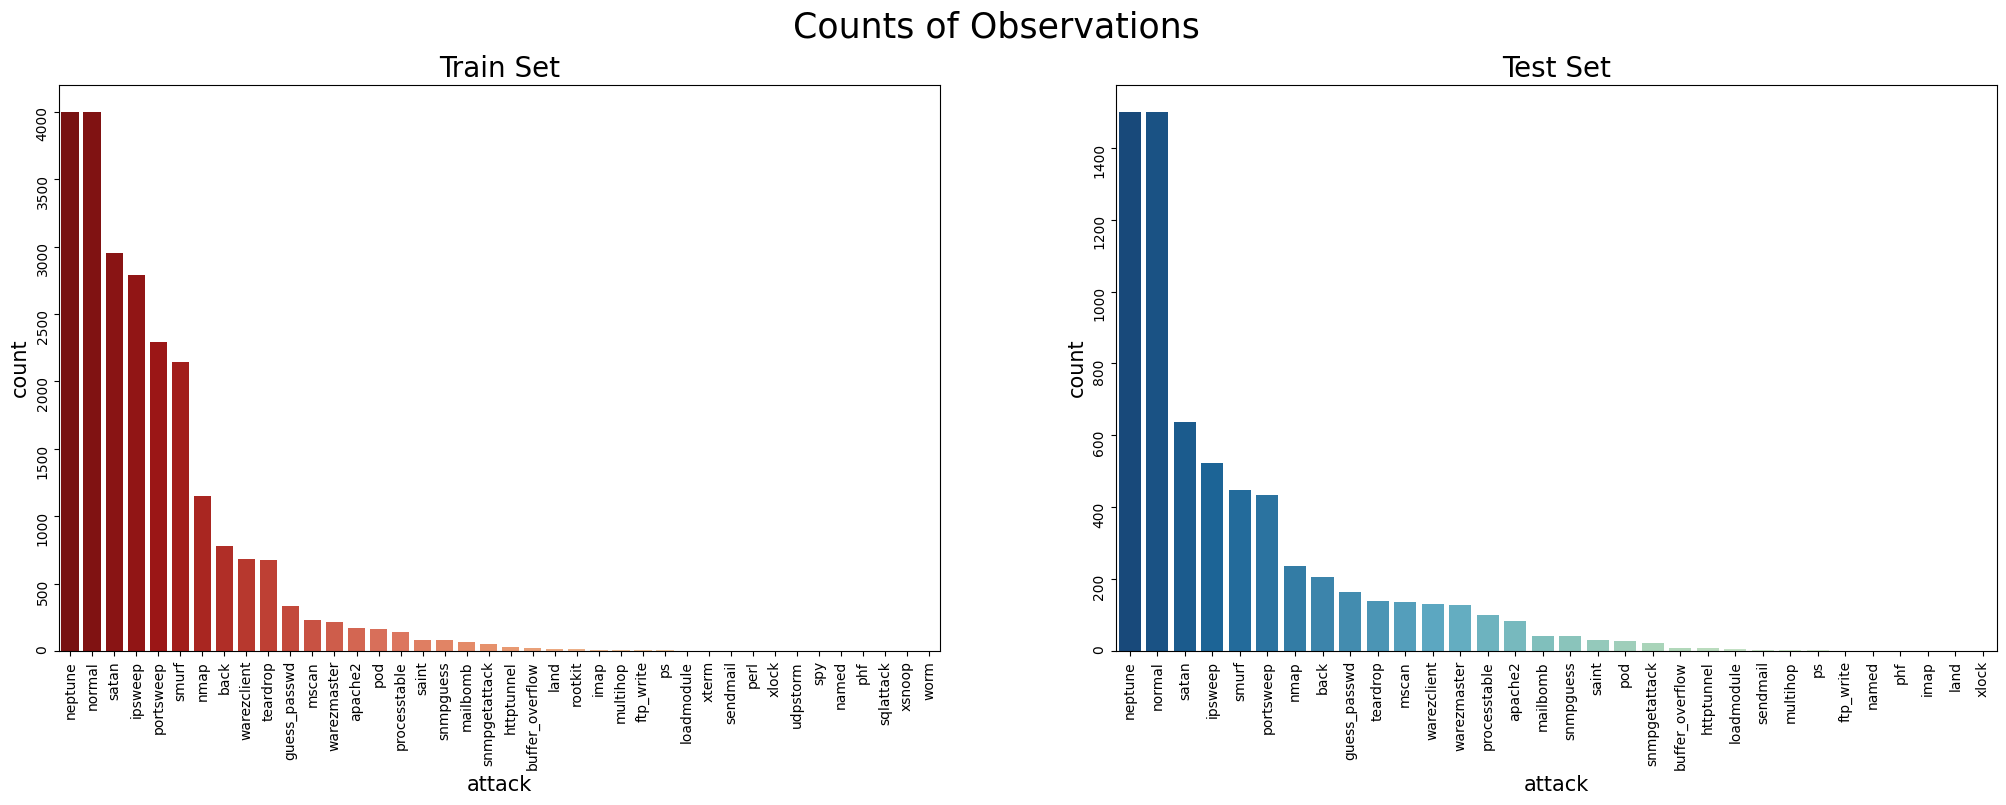

In [14]:
visualize(df_train_copy,df_test_copy,'attack')

There are 23 types of attack in the training dataset but 38 types of attack in the test dataset. Let's only keep the first 9 attack types from the training set and move everything else to a new category called 'other'. Let' do that on both sets.

In [15]:
keep_attacks = ['neptune', 'normal', 'satan', 'ipsweep', 'portsweep', 'smurf', 'nmap', 'back', 'teardrop']
df_train_copy['attack'] = df_train_copy['attack'].apply(lambda x: x if x in keep_attacks else 'other')
df_test_copy['attack'] = df_test_copy['attack'].apply(lambda x: x if x in keep_attacks else 'other')

Let's visualize again

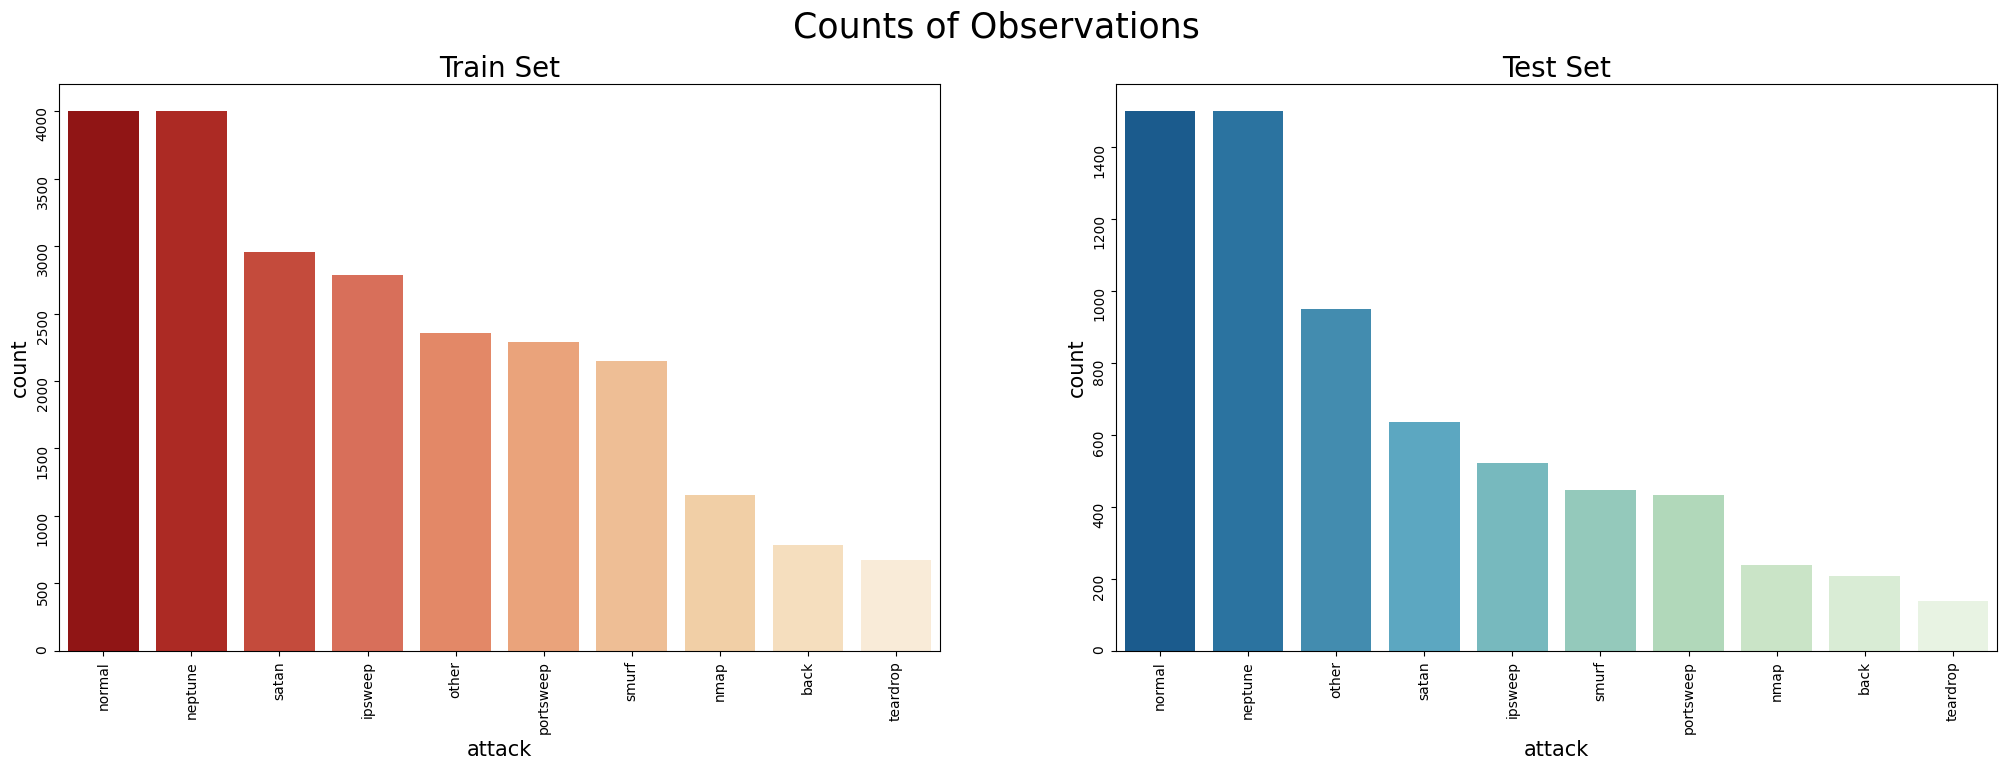

In [16]:
visualize(df_train_copy,df_test_copy,'attack')

Now, we have too much data in the 'other' category on the test side. Let's steal 60% of the other data from the test side and put them on the training side

In [17]:


#seed_random = 718
#test_split_size=0.40

#df_test_other_slice = df_test_copy[df_test_copy['attack']=='other'].copy()

#df_train_other_sample, df_test_other_sample = train_test_split(df_test_other_slice, test_size=test_split_size, random_state=seed_random)

#df_test_copy.drop(df_test_copy.loc[df_test_copy['attack']=='other'].index, inplace=True)

#df_train_copy = pd.concat([df_train_copy, df_train_other_sample], axis=0)
#df_test_copy = pd.concat([df_test_copy, df_test_other_sample], axis=0)

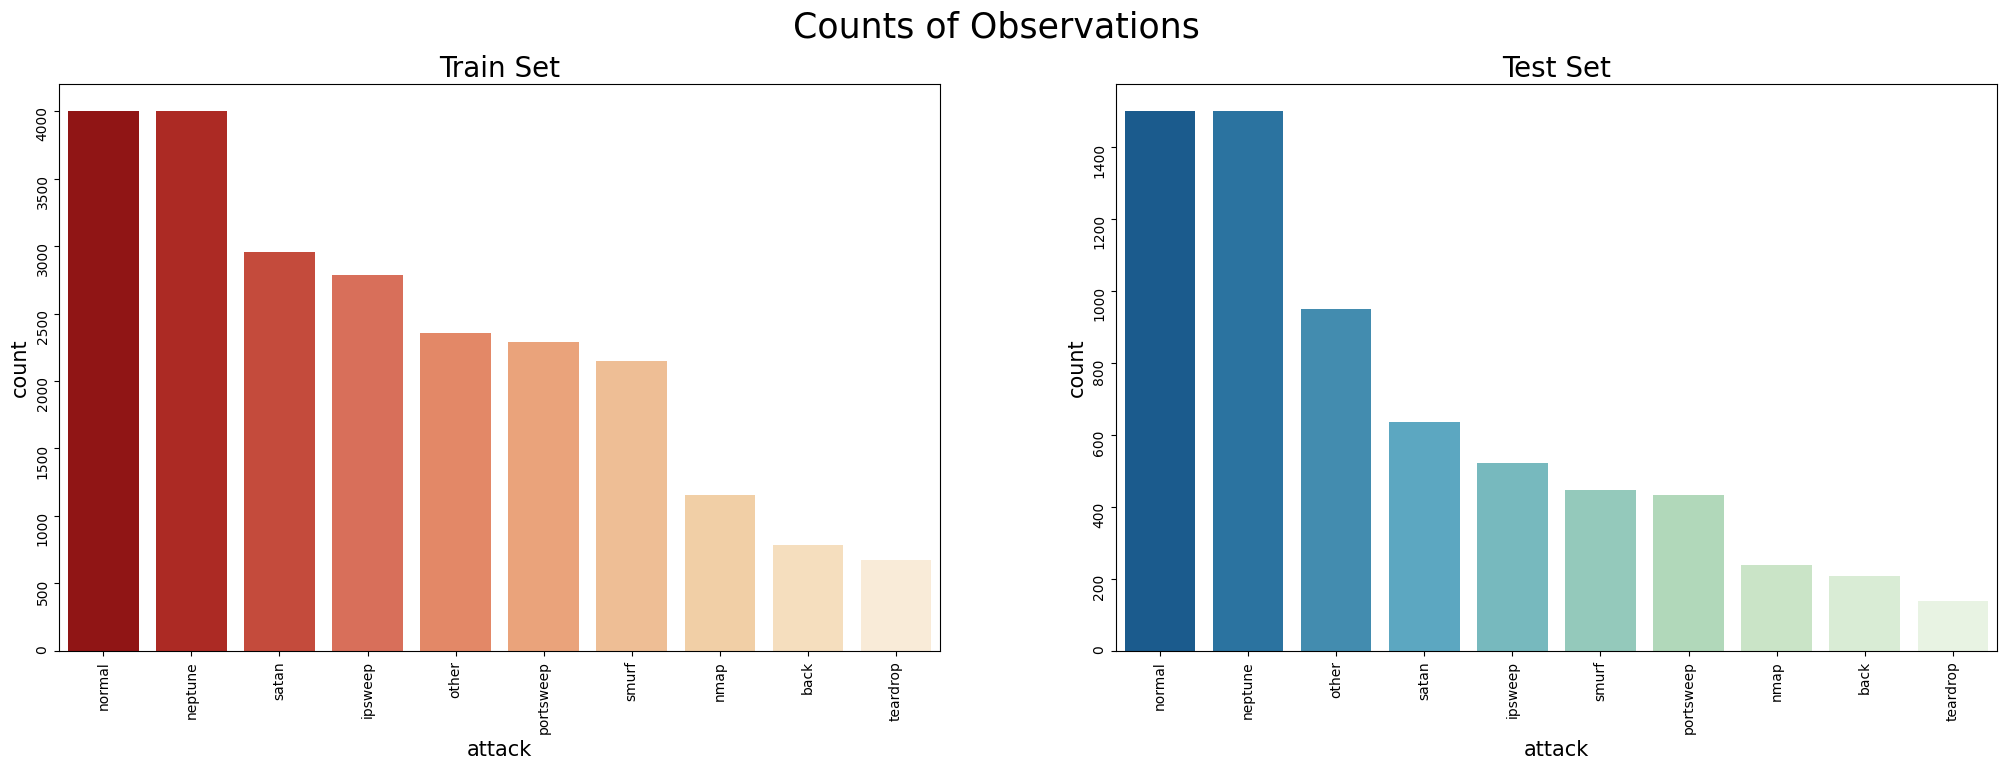

In [18]:
visualize(df_train_copy,df_test_copy,'attack')

Let's now look at the distribution of integer attributes that has more than 10 distinct values.

In [19]:
def plot_hist(df, cols, title):
    grid = gridspec.GridSpec(10, 2, wspace=0.5, hspace=0.5) 
    fig = plt.figure(figsize=(15,25)) 
    
    for n, col in enumerate(df[cols]):         
        ax = plt.subplot(grid[n]) 

        ax.hist(df[col], bins=20) 
        #ax.set_ylabel('Count', fontsize=12)
        ax.set_title(f'{col} distribution', fontsize=15) 
    
    fig.suptitle(title, fontsize=20)
    grid.tight_layout(fig, rect=[0, 0, 1, 0.97])
    plt.show()

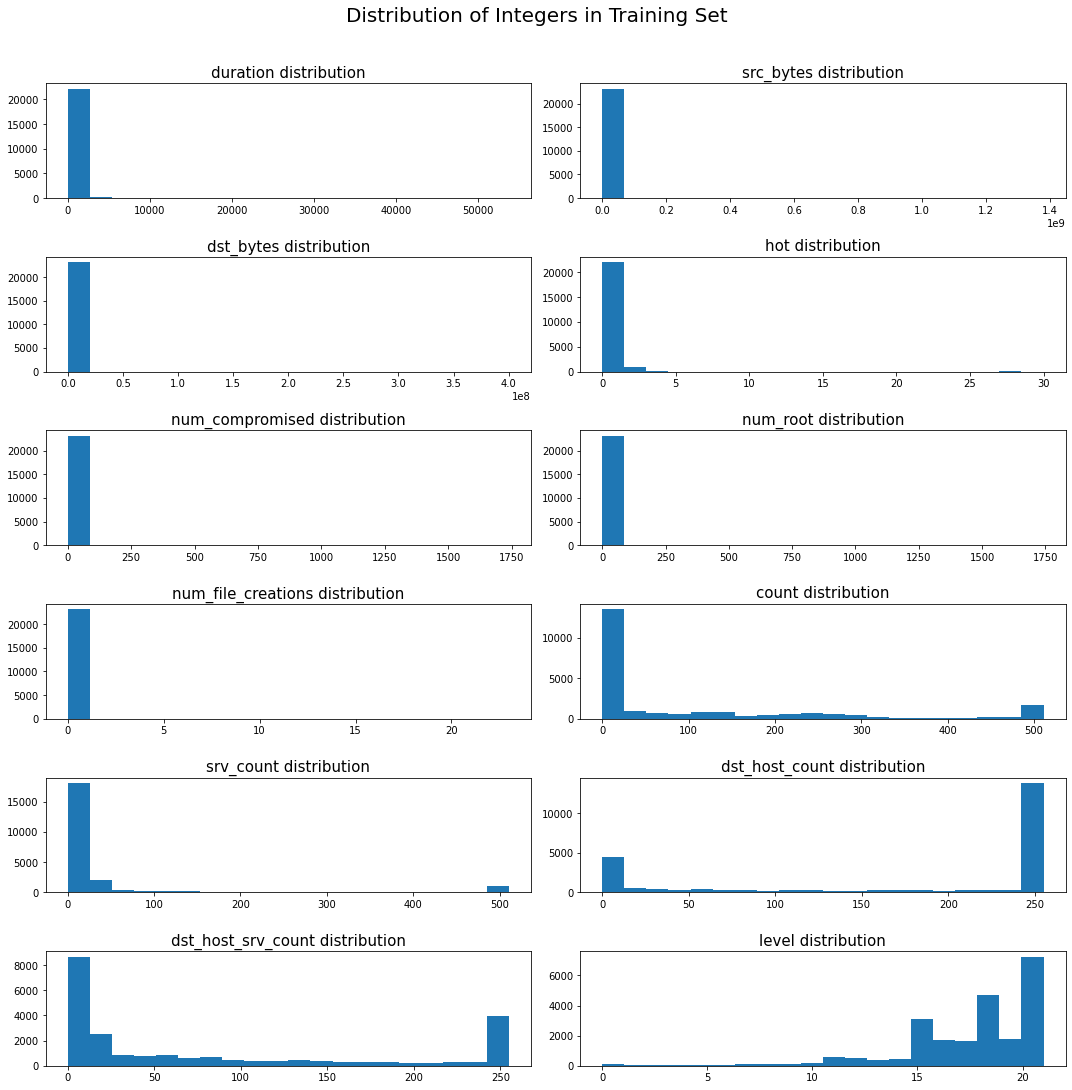

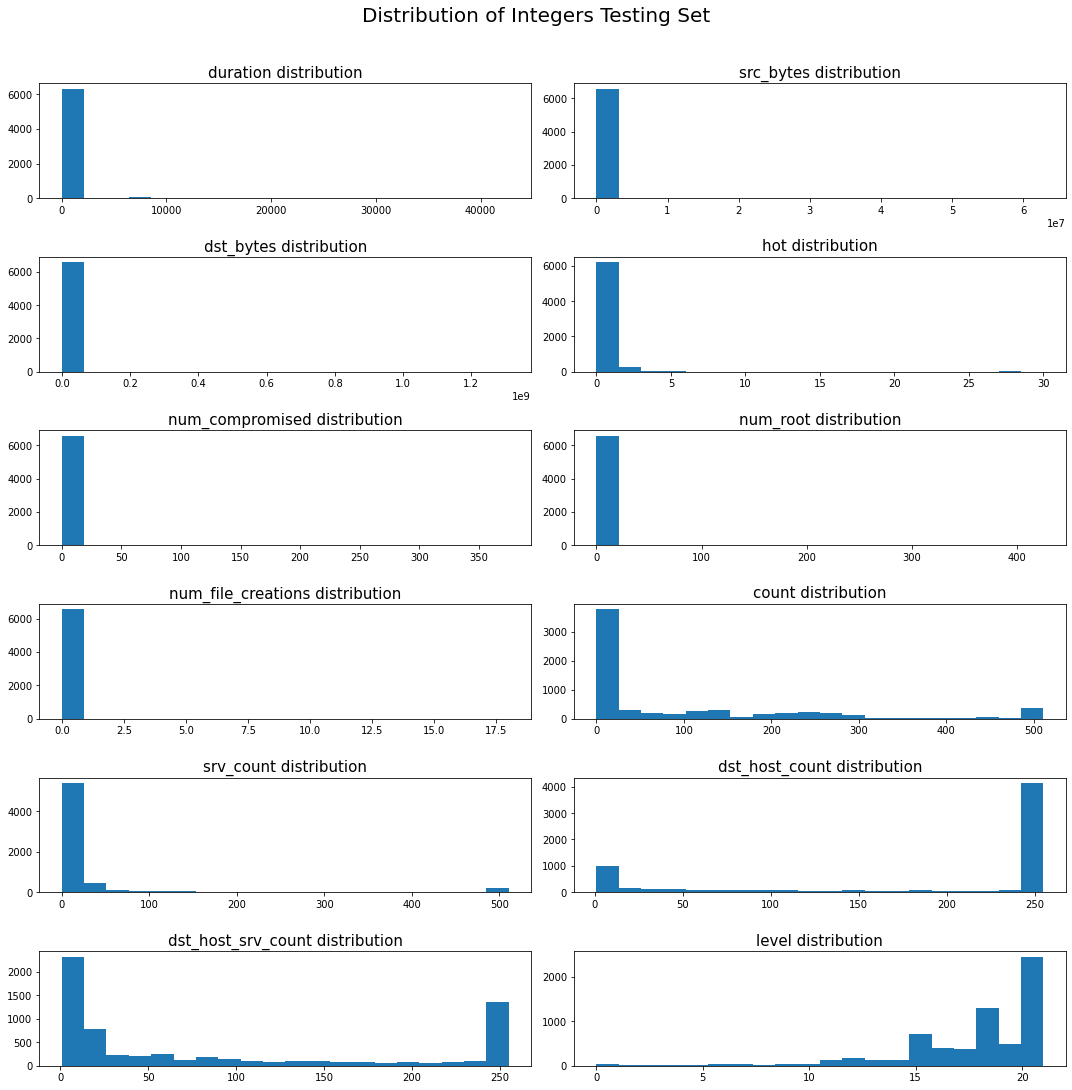

In [20]:
integer_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'num_root', 'num_file_creations', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count','level']

    
plot_hist(df_train_copy, integer_cols, 'Distribution of Integers in Training Set')
plot_hist(df_test_copy, integer_cols, 'Distribution of Integers Testing Set')

Let's covert them to their log values for a smoother distribution set

In [21]:
for col in integer_cols:
    df_train_copy[col] = np.log(df_train_copy[col]+1e-6)
    df_test_copy[col] = np.log(df_test_copy[col]+1e-6)



Let's plot them again

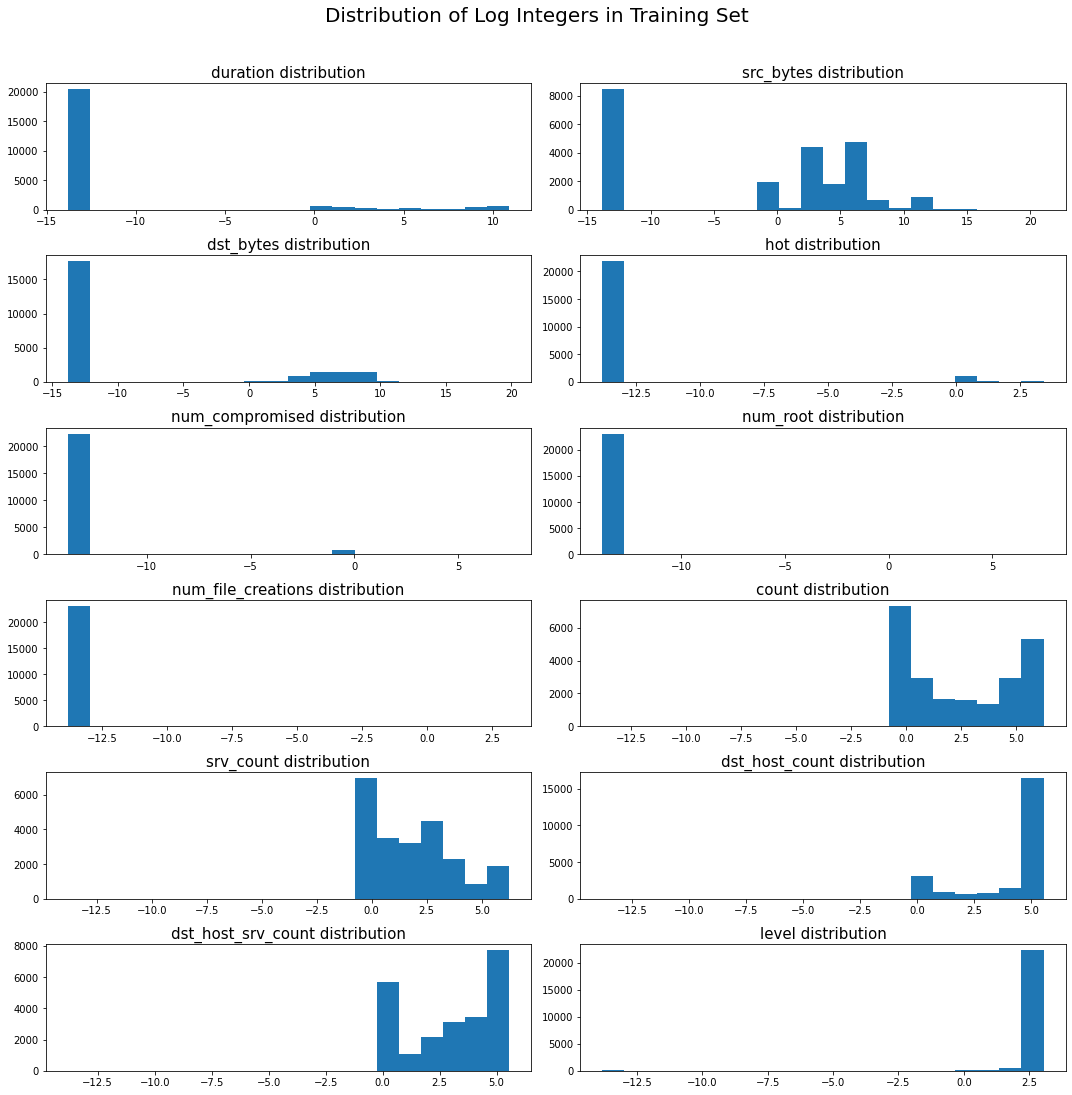

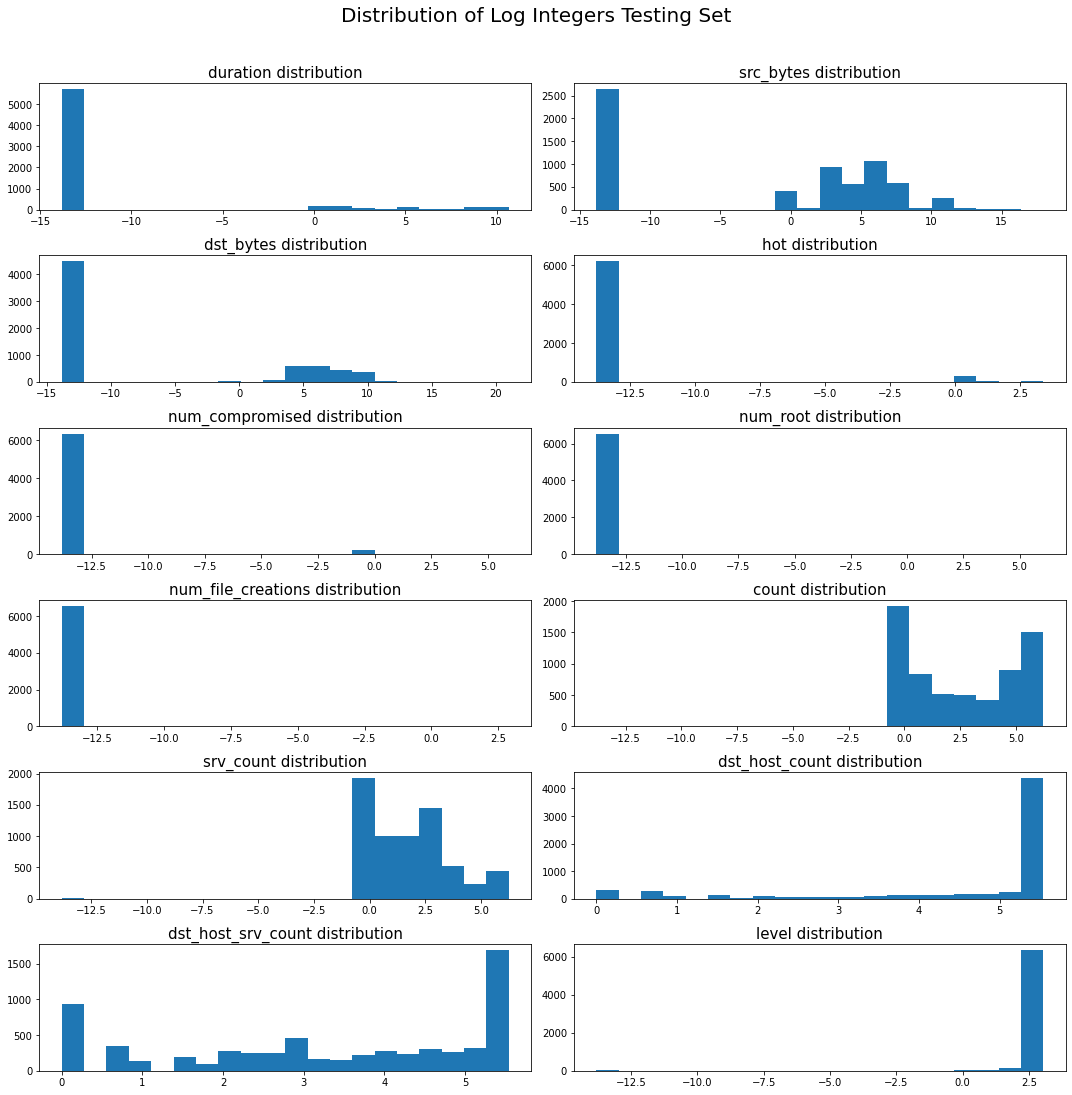

In [22]:
plot_hist(df_train_copy, integer_cols, 'Distribution of Log Integers in Training Set')
plot_hist(df_test_copy, integer_cols, 'Distribution of Log Integers Testing Set')

The look better now.

Let's now do one-hot encoding on categorical attributes like 'protocol_type', 'service' and 'flag' attributes. However, we have to be careful. There are 70 and 64 unique 'service' values in training and test dataset. This is a problem for one-hot encoding. To ensure consistent and accurate one-hot encoding, we will merge the training and test datasets, perform the one-hot transformation, and then split them back into their original partitions.

In [23]:
df_train_copy['train']=1                                                                       
df_test_copy['train']=0                                                                        

joined_df = pd.concat([df_train_copy, df_test_copy])                                           
 
protocol_dummies = pd.get_dummies(joined_df['protocol_type'], prefix='protocol_type')          
service_dummies = pd.get_dummies(joined_df['service'], prefix='service')                       
flag_dummies = pd.get_dummies(joined_df['flag'], prefix='flag')                                

joined_df = pd.concat([joined_df, protocol_dummies, service_dummies, flag_dummies], axis=1)    

df_train_copy = joined_df[joined_df['train']==1]                                               
df_test_copy = joined_df[joined_df['train']==0]                                                

drop_cols = ['train', 'protocol_type', 'service', 'flag']                                      

df_train_copy.drop(drop_cols, axis=1, inplace=True)                                            
df_test_copy.drop(drop_cols, axis=1, inplace=True)                                             


In [24]:
df_train_copy.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,...,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
62150,-13.815511,6.939254,-13.815511,0,0,0,-13.815511,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,6.236370e+00,6.236370e+00,0.00,0.0,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
112344,-13.815511,-13.815511,-13.815511,0,0,0,-13.815511,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,4.094345e+00,9.999995e-07,0.02,0.0,0.92,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
98291,-13.815511,-13.815511,-13.815511,0,0,0,-13.815511,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,9.999995e-07,9.999995e-07,0.00,0.0,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
79272,-13.815511,-13.815511,-13.815511,0,0,0,-13.815511,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,9.999995e-07,9.999995e-07,0.00,0.0,1.00,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
15976,-13.815511,-13.815511,3.784190,0,0,0,-13.815511,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,9.999995e-07,9.999995e-07,1.00,1.0,0.00,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [25]:
df_test_copy.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,...,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
9155,-1.381551e+01,3.583519,5.468060,0,0,0,-1.381551e+01,0,1,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,9.999995e-07,9.999995e-07,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7297,-1.381551e+01,10.906690,8.895630,0,0,0,9.999995e-07,0,1,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,6.931477e-01,6.931477e-01,0.0,0.0,0.5,0.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
90223,9.999995e-07,7.111512,7.804251,0,0,0,3.332205e+00,0,1,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,1,9.999995e-07,9.999995e-07,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16141,-1.381551e+01,4.653960,4.983607,0,0,0,-1.381551e+01,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,6.931477e-01,6.931477e-01,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
94686,-1.381551e+01,6.939254,-13.815511,0,0,0,-1.381551e+01,0,0,-13.815511,0,0,-13.815511,-13.815511,0,0,0,0,0,5.214936e+00,5.214936e+00,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Let's separate the features from the label

In [26]:
y_buffer = df_train_copy['attack'].copy()
x_buffer = df_train_copy.drop(['attack'], axis=1)

y_test = df_test_copy['attack'].copy()
x_test = df_test_copy.drop(['attack'], axis=1)

Time to separate training data from validation data

In [27]:
seed_random = 315

x_train, x_val, y_train, y_val = train_test_split(x_buffer, y_buffer, test_size=0.3, random_state=seed_random)

Let's build the model creation function

In [28]:
def create_model(input_size,output_size,my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  deep_model = Sequential()

  #input layer
  deep_model.add(Dense(256, input_dim=input_size, activation='softplus'))


  # 3 hidden layer
  deep_model.add(Dense(128, activation='relu', name='Hidden1'))
  # Define a dropout regularization layer. 
  #deep_model.add(tf.keras.layers.Dropout(rate=0.2))

  deep_model.add(Dense(64, activation='relu',name='Hidden2'))
  # Define a dropout regularization layer. 
  #deep_model.add(tf.keras.layers.Dropout(rate=0.2))

  deep_model.add(Dense(32, activation='relu',name='Hidden3'))
  # Define a dropout regularization layer. 
  #deep_model.add(tf.keras.layers.Dropout(rate=0.2))

  # output layer
  deep_model.add(Dense(output_size, activation='softmax'))

                          
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  
  deep_model.compile(loss='categorical_crossentropy', 
                   optimizer=Adam(learning_rate=my_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=True),
                   metrics=['accuracy'])
  
  return deep_model 

Let's create the model with all the features as input, all the attack categories as output and at a learning rate of 0.001 and train it.


In [29]:
def train_model(deep_model, train_features, train_label, epochs, 
                batch_size, validation_features, validation_label):
  """Train the model by feeding it data."""

  history = deep_model.fit(train_features, train_label, 
               epochs=epochs, 
               batch_size=batch_size,
               validation_data=(validation_features, validation_label))
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist  


Time to do one-hot encoding on the label column

In [30]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_buffer)

y_train_econded = label_encoder.transform(y_train)
y_val_econded = label_encoder.transform(y_val)
y_test_econded = label_encoder.transform(y_test)

y_train_dummy = np_utils.to_categorical(y_train_econded)
y_val_dummy = np_utils.to_categorical(y_val_econded)
y_test_dummy = np_utils.to_categorical(y_test_econded)

In [31]:
len(x_train.columns)
y_train.nunique()

10

Let's run the model with the finalized hyperparameters. I've conducted numerous trials and errors to arrive at the optimal set of hyperparameters for the model.

In [32]:
my_learning_rate=0.001
my_epochs = 40
my_batch_size = 2500

deep_model = create_model(len(x_train.columns),y_train.nunique(), my_learning_rate)
epochs, hist = train_model(deep_model=deep_model,train_features=x_train, 
                           train_label=y_train_dummy,epochs=my_epochs, 
                           batch_size = my_batch_size,
                           validation_features=x_val, validation_label=y_val_dummy)



Epoch 1/40
7/7 [==============================] - 2s 166ms/step - loss: 2.0946 - accuracy: 0.2909 - val_loss: 1.6453 - val_accuracy: 0.5328
Epoch 2/40
7/7 [==============================] - 1s 89ms/step - loss: 1.4671 - accuracy: 0.5590 - val_loss: 1.2404 - val_accuracy: 0.5978
Epoch 3/40
7/7 [==============================] - 1s 99ms/step - loss: 1.1331 - accuracy: 0.6129 - val_loss: 0.9868 - val_accuracy: 0.7031
Epoch 4/40
7/7 [==============================] - 1s 88ms/step - loss: 0.9139 - accuracy: 0.7281 - val_loss: 0.8158 - val_accuracy: 0.7294
Epoch 5/40
7/7 [==============================] - 0s 47ms/step - loss: 0.7585 - accuracy: 0.7589 - val_loss: 0.6744 - val_accuracy: 0.7885
Epoch 6/40
7/7 [==============================] - 0s 49ms/step - loss: 0.6271 - accuracy: 0.8131 - val_loss: 0.5669 - val_accuracy: 0.8247
Epoch 7/40
7/7 [==============================] - 0s 50ms/step - loss: 0.5223 - accuracy: 0.8473 - val_loss: 0.4810 - val_accuracy: 0.8534
Epoch 8/40
7/7 [==========

In [33]:
train_loss, train_accuracy=deep_model.evaluate(x=x_train, y=y_train_dummy, batch_size=my_batch_size)
print("Training Accuracy :", round(train_accuracy*100,2))
print("Training Loss :", train_loss)

val_loss, val_accuracy=deep_model.evaluate(x=x_val, y=y_val_dummy, batch_size=my_batch_size)
print("Validation Accuracy :", round(val_accuracy*100,2))
print("Validation Loss :", val_loss)


7/7 [==============================] - 0s 31ms/step - loss: 0.1138 - accuracy: 0.9633
Training Accuracy : 96.33
Training Loss : 0.11378291249275208
3/3 [==============================] - 0s 29ms/step - loss: 0.1424 - accuracy: 0.9549
Validation Accuracy : 95.49
Validation Loss : 0.1424434632062912


Impressive! The model has achieved an accuracy of over 94% on both the training set and the validation set.

Let's see the progress on the accuracy

In [34]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


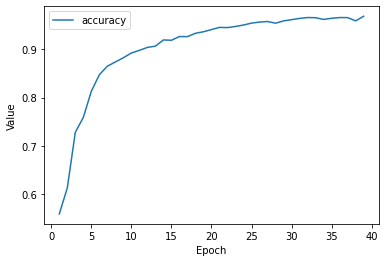

In [35]:
# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

It appears that the accuracy won't improve with further Epochs

In [36]:
predictions = deep_model.predict(x_val)
deep_val_pred = np.argmax(predictions, axis=-1)
deep_val_pred_decoded = label_encoder.inverse_transform(deep_val_pred)

test_predictions = deep_model.predict(x_test)
deep_test_pred = np.argmax(test_predictions, axis=-1)
deep_test_pred_decoded = label_encoder.inverse_transform(deep_test_pred)

206/206 [==============================] - 0s 2ms/step


In [37]:
def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    #y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

Let's plot the confusin matrix from the validation set

0.9383265279601343

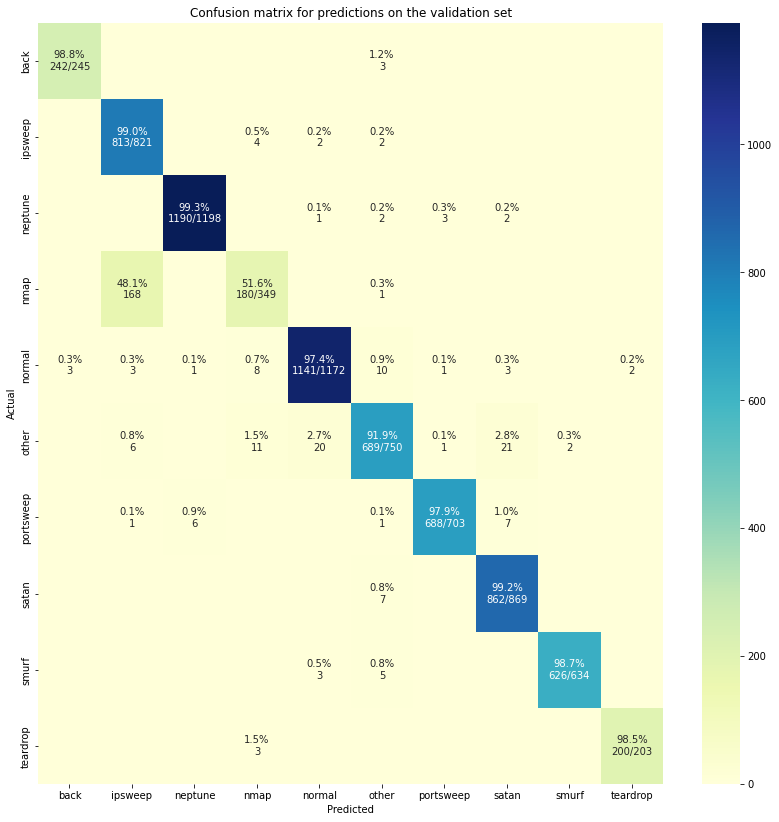

In [38]:
plot_cm(y_val, deep_val_pred_decoded, 'Confusion matrix for predictions on the validation set')
f1_score(y_val, deep_val_pred_decoded, average = 'macro')

On the validation dataset, the model was able to achieve over 95% accuracy for most of the categories, although it struggled with a few category predictions.

It's about time to evaluate the model's accuracy on the test dataset.

In [39]:
test_loss, test_accuracy=deep_model.evaluate(x=x_test, y=y_test_dummy, batch_size=my_batch_size)
print("Test Accuracy :", round(test_accuracy*100,2))
print("Test Loss :", test_loss)
cm = confusion_matrix(y_test, deep_test_pred_decoded, labels=np.unique(y_test))
# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, deep_test_pred_decoded)
# Calculate macro-average precision, recall, and F1 score
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1_score = np.mean(f1_score)
print("Test precision :", round(macro_precision*100,2))
print("Test recall :", round(macro_recall*100,2))
print("Test F1 :", round(macro_f1_score*100,2))



3/3 [==============================] - 0s 15ms/step - loss: 0.1184 - accuracy: 0.9664
Test Accuracy : 96.64
Test Loss : 0.11842223256826401
Test precision : 96.08
Test recall : 94.5
Test F1 : 94.88


Amazing! The model has achieved an accuracy of over 95% on the test dataset, which is even better than the accuracy on the validation set.

Let's check the confusion matrix on the test dataset.

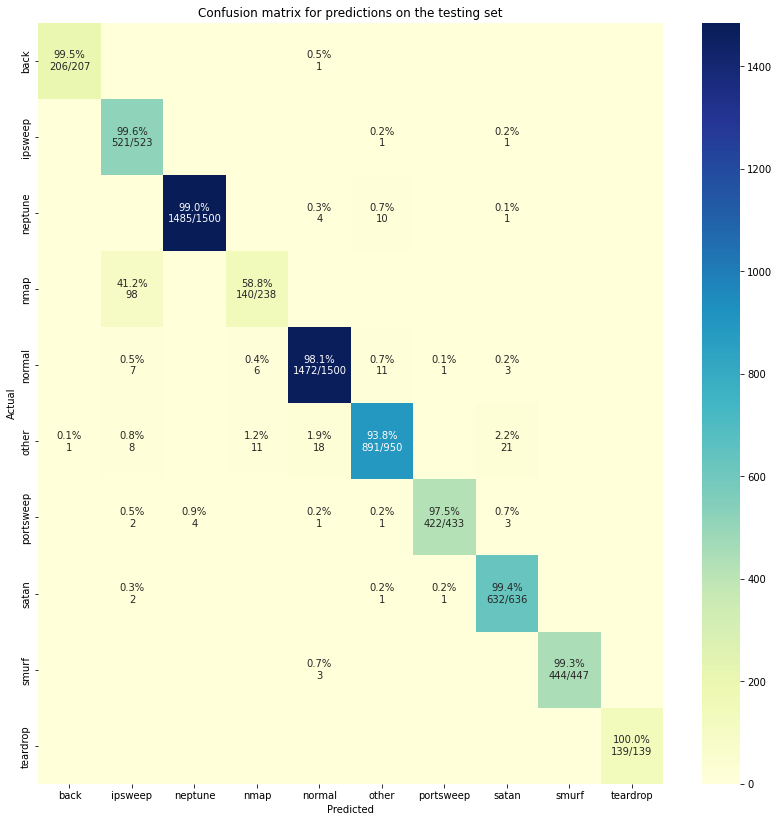

In [40]:
plot_cm(y_test, deep_test_pred_decoded, 'Confusion matrix for predictions on the testing set')
#f1_score(y_test, deep_test_pred_decoded, average = 'macro')

The model performed exceptionally well on all category predictions, except for the 'nmap' category

# ***We can confidently say that we have a reliable and effective model since it performed just as well on the test dataset as it did on the training and validation datasets, indicating that the model is not over-fitted.***